In [1]:
import os
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import TBXLoggerCallback
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.policy import Policy
import seaborn as sns

from stocktradingv2.agent.mydqn import MyDQNConfig, MyDQN
from stocktradingv2.env.SingleStockTradingEnv import SingleStockTradingEnv

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init()

2023-03-11 17:04:06,923	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
dict_df = {}
for root, dirs, files in os.walk("./datasets/CSI300/"):
    for file in files:
        path = os.path.join("./datasets/CSI300/", file)
        df = pd.read_csv(path)
        dict_df[path] = df

In [4]:
i = 0
list_tic = list(dict_df.keys())
list_df = [dict_df[k] for k in list_tic]

0.9030076685093477


<AxesSubplot: ylabel='close_'>

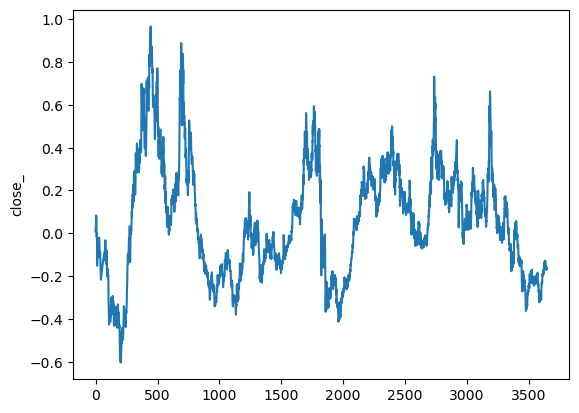

In [5]:
df = list_df[0]
df.rename(columns={"close_": "close", "close": "close_"}, inplace=True)
print(np.log(df.close.iloc[-1]/df.close.iloc[0]))
sns.lineplot(df.close)

In [6]:
test_start = '2017-01-01'
trade_start = '2020-01-01'
test_start = pd.to_datetime(test_start, format='%Y-%m-%d')
trade_start = pd.to_datetime(trade_start, format='%Y-%m-%d')

df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df_train = df.loc[df.date < test_start].sort_index(ascending=True).copy()
df_test = df.loc[(df.date >= test_start) & (df.date < trade_start)].sort_index(ascending=True).copy()
df_trade = df.loc[df.date >= trade_start].sort_index(ascending=True).copy()

-0.003613726446537048


<AxesSubplot: ylabel='close'>

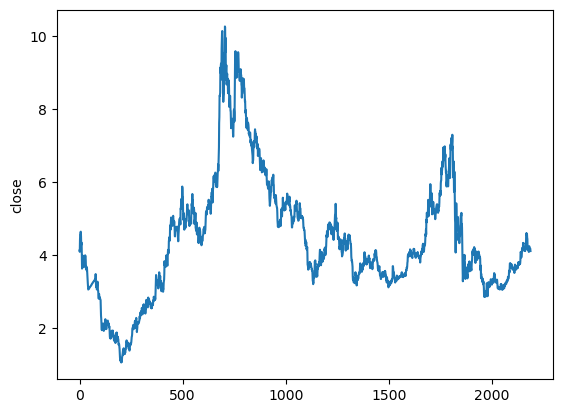

In [7]:
print(np.log(df_train.close.iloc[-1]/df_train.close.iloc[0]))
sns.lineplot(df_train.close)

In [17]:
class MyCallbacks(DefaultCallbacks):
    def __init__(self, legacy_callbacks_dict: Dict[str, callable] = None):
        self._eval_counter = 0
        self._train_counter = 0
        super().__init__(legacy_callbacks_dict)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: EpisodeV2,
        env_index: int,
        **kwargs
    ):
        env = base_env.get_sub_environments()[0]

        episode.custom_metrics["total_trading"] = env.total_trading
        episode.custom_metrics["success_rate"] = env.success_trade / env.total_trading
        episode.custom_metrics["log-ret"] = np.log(env.asset_memory[-1] / env.asset_memory[0])
        # episode.hist_data["action_memory"] = env.action_memory
        # episode.hist_data["asset_memory"] = env.asset_memory

        df = pd.DataFrame(
            data={
            "date": env.date,
            "prices": env.prices,
            "action": [1] + env.action_memory,
            "asset": env.asset_memory
            }
        )
        df.loc[df.action == 1, "action"] = np.nan
        fig, ax = plt.subplots()
        sns.lineplot(x=df.date, y=df.prices, ax=ax)
        # plot buying action
        sns.scatterplot(
            x=df.date[df.action == 0], 
            y=df.prices[df.action == 0],  
            markers="^", 
            ax=ax
        )
        # plot selling action
        sns.scatterplot(
            x=df.date[df.action == 2], 
            y=df.prices[df.action == 2], 
            markers="v", 
            ax=ax
        )

        in_eval =  worker.policy_config["in_evaluation"]
        dqn_type = worker.policy_config["model"]["custom_model_config"] ["type"]
        if in_eval:
            fig.savefig(f"./{dqn_type}_{self._eval_counter}_{episode.episode_id:05d}.png")
            self._eval_counter += 1
        else:
            if self._train_counter % 10 == 0:
                fig.savefig(f"./{dqn_type}_{self._train_counter}_{episode.episode_id:05d}.png")
            self._train_counter += 1

In [18]:
param_space = {
    "framework": "torch",
    "env": "SingleStockTrading",
    "disable_env_checking": True,
    "env_config": {
        "df": df_train,
        # "verbose": True,
    },

    # "num_workers": 5,
    # "num_envs_per_worker": 10,
    # "num_cpus_per_worker": 1,

    "model": {
        "custom_model_config": {
            "type": tune.grid_search(["dqn", "iqn", "qrdqn", "cqn"]) ,
            "vmin": -10,
            "vmax": 10,
            "lstm_dim": 64,
            "net_arch": [64],
            "action_mask_fn": SingleStockTradingEnv.action_mask_fn,
            "num_atoms": 50,
            "cos_embedding_dim": 64,
            "risk_distortion_measure": None,
        }
    },

    #"min_sample_timesteps_per_iteration": 64,
    "min_train_timesteps_per_iteration": 64,
    
    "exploration_config": {
            "type": "EpsilonGreedy",
            "initial_epsilon": 1.0,
            "final_epsilon": 0.02,
            "epsilon_timesteps": 10000,
    },
    "callbacks": MyCallbacks,

    "evaluation_interval": 3,
    "evaluation_duration": 1,
    "evaluation_duration_unit": "episodes",
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "explore": False,
        "env_config": {
            "df": df_test,
        },
    }
}

In [19]:
tuner = tune.Tuner(
    MyDQN, 
    param_space=param_space,
    tune_config=tune.TuneConfig(num_samples=1),
    run_config=air.RunConfig(
        progress_reporter=JupyterNotebookReporter(),
        stop={
            "episode_reward_mean": 10,
            "timesteps_total": 100000,
        },
        callbacks=[TBXLoggerCallback()],
    )
)
results = tuner.fit()

(MyDQN pid=17236) 2023-03-11 17:54:09,770	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=17236) 2023-03-11 17:54:10,109	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=17236) 2023-03-11 17:54:15,643	WARNING util.py:67 -- Install gputil for GPU system monitoring.


(MyDQN pid=17236) episode 435125245854515230 (env-idx=0) started.


(MyDQN pid=8616) 2023-03-11 17:54:20,838	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=8616) 2023-03-11 17:54:21,189	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=8616) 2023-03-11 17:54:26,528	WARNING util.py:67 -- Install gputil for GPU system monitoring.


(MyDQN pid=8616) episode 100811645488580798 (env-idx=0) started.


(MyDQN pid=13560) 2023-03-11 17:54:32,476	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=13560) 2023-03-11 17:54:32,914	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=13560) 2023-03-11 17:54:39,149	WARNING util.py:67 -- Install gputil for GPU system monitoring.


(MyDQN pid=13560) episode 139742625196465270 (env-idx=0) started.


(MyDQN pid=12420) 2023-03-11 17:54:45,766	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=12420) 2023-03-11 17:54:46,238	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=12420) 2023-03-11 17:54:52,873	WARNING util.py:67 -- Install gputil for GPU system monitoring.


(MyDQN pid=12420) episode 822631912573603417 (env-idx=0) started.


(MyDQN pid=17236) episode 671742324076359317 (env-idx=0) started.
(MyDQN pid=13560) episode 414245675165268908 (env-idx=0) started.
(MyDQN pid=12420) episode 500774624185898068 (env-idx=0) started.
(RolloutWorker pid=16268) episode 145046286120062270 (env-idx=0) started.
(RolloutWorker pid=11520) episode 260719357951389106 (env-idx=0) started.
(MyDQN pid=13560) episode 526073712302042177 (env-idx=0) started.
(MyDQN pid=17236) episode 667102545058646735 (env-idx=0) started.
(MyDQN pid=8616) episode 586940128166142939 (env-idx=0) started.
(MyDQN pid=12420) episode 895910011443515991 (env-idx=0) started.
(RolloutWorker pid=11520) episode 680805795107909726 (env-idx=0) started.
(RolloutWorker pid=2016) episode 210281337141440953 (env-idx=0) started.
(MyDQN pid=13560) episode 438521885231604387 (env-idx=0) started.
(MyDQN pid=17236) episode 97110569422319594 (env-idx=0) started.
(MyDQN pid=12420) episode 206587286157745614 (env-idx=0) started.
(MyDQN pid=13560) episode 209568039948587384 (e

(MyDQN pid=13560) C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_16964\1904496841.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


(MyDQN pid=13560) episode 843475483984740456 (env-idx=0) started.
(MyDQN pid=12420) episode 817536384048324608 (env-idx=0) started.


(MyDQN pid=17236) C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_16964\1904496841.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


(MyDQN pid=17236) episode 883893586044719511 (env-idx=0) started.
(RolloutWorker pid=11520) episode 514591509054339492 (env-idx=0) started.
(MyDQN pid=13560) episode 618148947926760429 (env-idx=0) started.
(MyDQN pid=8616) episode 757312821002724495 (env-idx=0) started.
(MyDQN pid=12420) episode 754631568830434245 (env-idx=0) started.
(MyDQN pid=17236) episode 458037872238285858 (env-idx=0) started.
(MyDQN pid=13560) episode 513761911743227491 (env-idx=0) started.



(MyDQN pid=12420) C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_16964\1904496841.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


(MyDQN pid=12420) episode 849923623525905386 (env-idx=0) started.
(MyDQN pid=13560) episode 759409800505015338 (env-idx=0) started.
(MyDQN pid=8616) episode 897163434297676231 (env-idx=0) started.
(MyDQN pid=13560) episode 222961508209136439 (env-idx=0) started.
(MyDQN pid=17236) episode 169811417178541387 (env-idx=0) started.
(RolloutWorker pid=21232) episode 952992818695265572 (env-idx=0) started.
(MyDQN pid=12420) episode 231879010308458207 (env-idx=0) started.
(MyDQN pid=13560) episode 594447640253636955 (env-idx=0) started.
(MyDQN pid=17236) episode 164622737439064607 (env-idx=0) started.


(MyDQN pid=13560) 2023-03-11 22:05:51,525	WARNING policy.py:126 -- Can not figure out a durable policy name for <class 'stocktradingv2.agent.mydqn.my_dqn_policy.MyDQNPolicy'>. You are probably trying to checkpoint a custom policy. Raw policy class may cause problems when the checkpoint needs to be loaded in the future. To fix this, make sure you add your custom policy in rllib.algorithms.registry.POLICIES.


In [ ]:
result = results.get_best_result(metric="episode_reward_mean", mode="max")
cp = result.best_checkpoints[0][0]
algo = MyDQN.from_checkpoint(cp)

In [ ]:
def get_envs(n_tickers: int = 10, seed=None) -> Tuple[MultiStockTradingEnv, MultiStockTradingEnv, MultiStockTradingEnv]:
    assert n_tickers <= len(df_dict_train)

    env_list = list()
    random.seed(seed)
    tic_list = random.sample(df_dict_train.keys(), n_tickers)
    print('Sampled tickers: ', tic_list)
    for _df_dict in [df_dict_train, df_dict_test, df_dict_trade]:
        if len(_df_dict[tic_list[0]]) == 0:
            env_list.append(None)
        else:
            _dfs = list()
            for tic in tic_list:
                _df = _df_dict[tic].copy()
                _df['tic'] = tic
                _dfs.append(_df)
            _dfs = pd.concat(_dfs)
            # drop dates that missing data
            _dfs = _dfs.pivot_table(index=['date'], columns=['tic']).dropna().stack().reset_index()
            _dfs.sort_values(['date', 'tic'], inplace=True)
            _dfs.set_index(['date', 'tic'], inplace=True)
            env_list.append(Monitor(MultiStockTradingEnv(_dfs, stack_frame=10)))
    
    return tuple(env_list)